In [ ]:
import sys
import time
import os.path
from glob import glob
from datetime import datetime, timedelta

import h5py
import numpy as np

sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/Analog_BC/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/Analog_BC/utils/')
sys.path.insert(0, '/glade/u/home/ksha/PUBLISH/fcstpp/')

import data_utils as du
import graph_utils as gu
from fcstpp import metrics

from namelist import * 

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# graph tools
import cmaps
import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from matplotlib import ticker
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

In [4]:
need_publish = False

# True: publication quality figures
# False: low resolution figures in the notebook

if need_publish:
    dpi_ = fig_keys['dpi']
else:
    dpi_ = 75

In [5]:
N_fcst = 54

In [6]:
# importing domain information
with h5py.File(save_dir+'BC_domain_info.hdf', 'r') as h5io:
    base_lon = h5io['base_lon'][...]
    base_lat = h5io['base_lat'][...]
    bc_lon = h5io['bc_lon'][...]
    bc_lat = h5io['bc_lat'][...]
    etopo_bc = h5io['etopo_bc'][...]
    land_mask = h5io['land_mask_base'][...]
    land_mask_bc = h5io['land_mask_bc'][...]

In [7]:
# mon_rain = np.array([9, 10, 11, 0, 1, 2])
# mon_dry = np.array([3, 4, 5, 6, 7, 8])

# base = datetime(2017, 1, 1)
# date_list = [base + timedelta(days=x) for x in range(365+365+365)]

# rain_inds = np.zeros((len(date_list),), dtype=bool)
# dry_inds = np.zeros((len(date_list),), dtype=bool)

# mon_inds = []
# for d, date in enumerate(date_list):
    
#     mon_inds.append(date.month-1)
#     if date.month-1 in mon_dry:
#         dry_inds[d] = True
#     else:
#         rain_inds[d] = True
        
# mon_inds = np.array(mon_inds)

# fcst_leads = np.arange(3, 72*3+3, 3, dtype=np.float)

# date_base = datetime(2019, 1, 1, 0)
# UTC_H = []
# DAYS = []
# for lead in fcst_leads:
#     date_temp = date_base + timedelta(hours=lead)
#     UTC_H.append(date_temp.hour)
#     DAYS.append(date_temp.day-1)
    
# DAY_inds = np.array(DAYS)[1:N_fcst+1]

# # import station obsevations and grid point indices
# with h5py.File(save_dir+'BCH_ERA5_3H_verif.hdf', 'r') as h5io:
#     ERA5_obs = h5io['ERA5_obs'][...]
#     BCH_obs = h5io['BCH_obs'][...]
#     indx = h5io['indx'][...]
#     indy = h5io['indy'][...]
    
# # importing domain info
# with h5py.File(save_dir+'BC_domain_info.hdf', 'r') as h5io:
#     land_mask_bc = h5io['land_mask_bc'][...]

# # importing girdded ERA5 quantiles
# with h5py.File(ERA_dir+'PT_3hour_quantile.hdf', 'r') as h5io:
#     CDF_era = h5io['CDF'][...]
#     q_bins = h5io['q'][...]

# CDF_obs = np.empty((12, 105,)+land_mask_bc.shape)
# CDF_obs[..., ~land_mask_bc] = CDF_era
# CDF_obs = CDF_obs[..., indx, indy]

# # station and monthly (contains neighbouring months) wise 90th
# BCH_90th = CDF_obs[:, 93, :] 

# dry_mon_ind = np.array([False, False, False, True, True, True, True, True, True, False, False, False])
# rain_mon_ind = np.logical_not(dry_mon_ind)

# print('cool season 90-th = {}'.format(np.median(BCH_90th[rain_mon_ind, :])))
# print('dry season 90-th = {}'.format(np.median(BCH_90th[dry_mon_ind, :])))

# with h5py.File(save_dir+'BCH_MODEL_pairs.hdf', 'r') as h5io:
#     BCH_BASE = h5io['BASE_final'][...]
#     BCH_BCNN = h5io['BASE_CNN'][...]
#     BCH_SL = h5io['SL_final'][...]
#     BCH_SCNN = h5io['SL_CNN'][...]
#     BCH_GEFS = h5io['GEFS'][...]
#     BCH_ERA5 = h5io['ERA5'][...]
    
# years = [2017, 2018, 2019]

# N_days = 366 + 365*3
# date_base = datetime(2016, 1, 1)
# date_list = [date_base + timedelta(days=x) for x in np.arange(N_days, dtype=np.float)]

# flag_pick = []
# for date in date_list:
#     if date.year in years:
#         flag_pick.append(True)
#     else:
#         flag_pick.append(False)

# flag_pick = np.array(flag_pick)
    
# BCH_obs = BCH_obs[flag_pick, ...]
# ERA5_obs = ERA5_obs[flag_pick, ...]

# def ETS_verif(model, obs, thres, DAY_inds):
#     N_days = np.max(DAY_inds) + 1
#     ETS_out = np.empty((N_days,))
#     BIAS_out = np.empty((N_days,))
    
#     for i in range(7):
#         flag_pick = DAY_inds == i
#         model_ = model[:, flag_pick, :].ravel()
#         obs_ = obs[:, flag_pick, :].ravel()
        
#         flag_nan = ~np.isnan(obs_)
        
#         ETS_out[i] = metrics.ETS(obs_[flag_nan]>thres, model_[flag_nan]>thres)
#         BIAS_out[i] = metrics.freq_bias(obs_[flag_nan]>thres, model_[flag_nan]>thres)
#     return ETS_out, BIAS_out

# thres = 1.3326865092570004

# ETS_GEFS_rain, BIAS_GEFS_rain = ETS_verif(BCH_GEFS[rain_inds, ...], BCH_obs[rain_inds, ...], thres, DAY_inds)
# ETS_ERA5_rain, BIAS_ERA5_rain = ETS_verif(BCH_ERA5[rain_inds, ...], BCH_obs[rain_inds, ...], thres, DAY_inds)
# ETS_BASE_rain, BIAS_BASE_rain = ETS_verif(BCH_BASE[rain_inds, ...], BCH_obs[rain_inds, ...], thres, DAY_inds)
# ETS_BCNN_rain, BIAS_BCNN_rain = ETS_verif(BCH_BCNN[rain_inds, ...], BCH_obs[rain_inds, ...], thres, DAY_inds)
# ETS_SL_rain, BIAS_SL_rain = ETS_verif(BCH_SL[rain_inds, ...], BCH_obs[rain_inds, ...], thres, DAY_inds)
# ETS_SCNN_rain, BIAS_SCNN_rain = ETS_verif(BCH_SCNN[rain_inds, ...], BCH_obs[rain_inds, ...], thres, DAY_inds)

# thres = 1.0829320819142252

# ETS_GEFS_dry, BIAS_GEFS_dry = ETS_verif(BCH_GEFS[dry_inds, ...], BCH_obs[dry_inds, ...], thres, DAY_inds)
# ETS_ERA5_dry, BIAS_ERA5_dry = ETS_verif(BCH_ERA5[dry_inds, ...], BCH_obs[dry_inds, ...], thres, DAY_inds)
# ETS_BASE_dry, BIAS_BASE_dry = ETS_verif(BCH_BASE[dry_inds, ...], BCH_obs[dry_inds, ...], thres, DAY_inds)
# ETS_BCNN_dry, BIAS_BCNN_dry = ETS_verif(BCH_BCNN[dry_inds, ...], BCH_obs[dry_inds, ...], thres, DAY_inds)
# ETS_SL_dry, BIAS_SL_dry = ETS_verif(BCH_SL[dry_inds, ...], BCH_obs[dry_inds, ...], thres, DAY_inds)
# ETS_SCNN_dry, BIAS_SCNN_dry = ETS_verif(BCH_SCNN[dry_inds, ...], BCH_obs[dry_inds, ...], thres, DAY_inds)

# ETS = {}
# ETS['gfs_rain'] = ETS_GEFS_rain
# ETS['era_rain'] = ETS_ERA5_rain
# ETS['base_rain'] = ETS_BASE_rain
# ETS['bcnn_rain'] = ETS_BCNN_rain
# ETS['sl_rain'] = ETS_SL_rain
# ETS['scnn_rain'] = ETS_SCNN_rain

# ETS['gfs_dry'] = ETS_GEFS_dry
# ETS['era_dry'] = ETS_ERA5_dry
# ETS['base_dry'] = ETS_BASE_dry
# ETS['bcnn_dry'] = ETS_BCNN_dry
# ETS['sl_dry'] = ETS_SL_dry
# ETS['scnn_dry'] = ETS_SCNN_dry

# BIAS = {}
# BIAS['gfs_rain'] = BIAS_GEFS_rain
# BIAS['era_rain'] = BIAS_ERA5_rain
# BIAS['base_rain'] = BIAS_BASE_rain
# BIAS['bcnn_rain'] = BIAS_BCNN_rain
# BIAS['sl_rain'] = BIAS_SL_rain
# BIAS['scnn_rain'] = BIAS_SCNN_rain

# BIAS['gfs_dry'] = BIAS_GEFS_dry
# BIAS['era_dry'] = BIAS_ERA5_dry
# BIAS['base_dry'] = BIAS_BASE_dry
# BIAS['bcnn_dry'] = BIAS_BCNN_dry
# BIAS['sl_dry'] = BIAS_SL_dry
# BIAS['scnn_dry'] = BIAS_SCNN_dry

# np.save(save_dir+'ETS_BCH.npy', ETS)
# np.save(save_dir+'BIAS_BCH.npy', BIAS)

In [8]:
ETS = np.load(save_dir+'ETS_BCH.npy', allow_pickle=True)[()]
BIAS = np.load(save_dir+'BIAS_BCH.npy', allow_pickle=True)[()]

In [9]:
cmap_pct, A = gu.precip_cmap()

gray = [0.5, 0.5, 0.5]

KW = {}
KW['era'] = {'linestyle': '-', 'color': 'w', 'linewidth':2.5}
KW['base'] = {'linestyle': '-', 'color': orange, 'linewidth':2.5}
KW['bcnn'] = {'linestyle': '--', 'color': red, 'linewidth':2.5}
KW['sl'] = {'linestyle': '-', 'color': cyan, 'linewidth':2.5}
KW['scnn'] = {'linestyle': '--', 'color': blue, 'linewidth':2.5}
KW['gfs'] = {'linestyle': '-', 'color': gray, 'linewidth':2.5}
KW['gfs_raw'] = {'linestyle': ':', 'color': gray, 'linewidth':1.5}

kw_bar = {'bottom':0.0, 'width': 3.0, 'color': '0.75', 'edgecolor': 'k', 'linestyle': '-', 'linewidth': 0}
kw_step = {'color': 'k', 'linestyle': '-', 'linewidth': 1.5, 'where':'mid'}

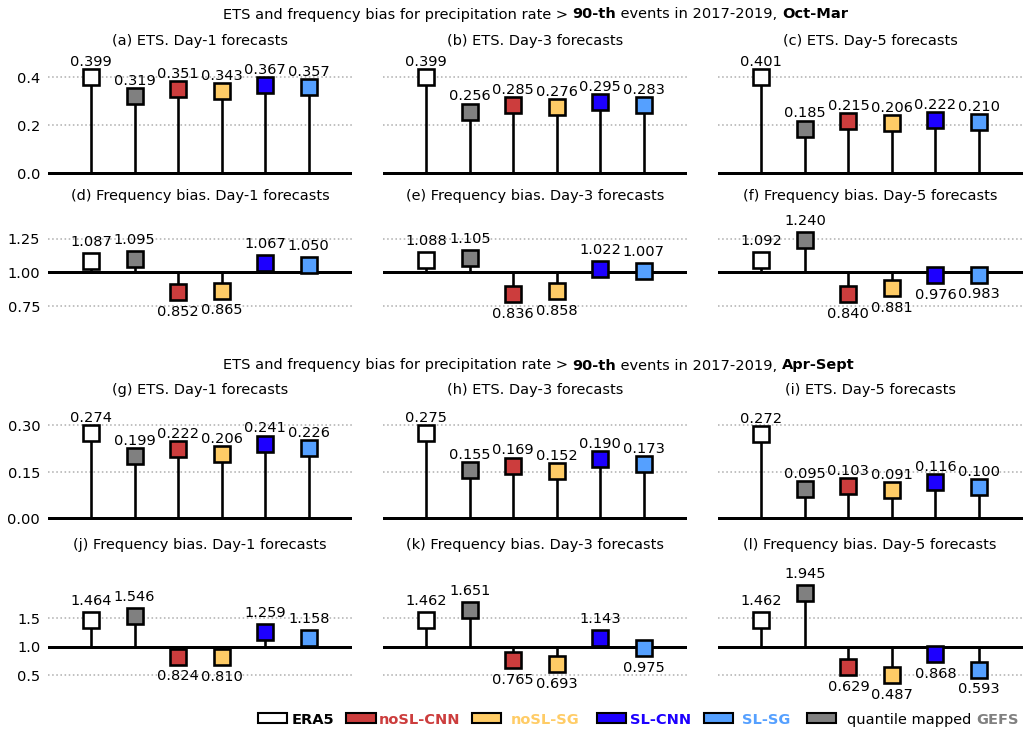

In [10]:
fig = plt.figure(figsize=(13, 9), dpi=dpi_)
gs = gridspec.GridSpec(6, 3, height_ratios=[0.1, 1, 1, 0.25, 1, 1], width_ratios=[1, 1, 1])

ax00 = plt.subplot(gs[1, 0])
ax01 = plt.subplot(gs[1, 1])
ax02 = plt.subplot(gs[1, 2])

ax10 = plt.subplot(gs[2, 0])
ax11 = plt.subplot(gs[2, 1])
ax12 = plt.subplot(gs[2, 2])

ax20 = plt.subplot(gs[4, 0])
ax21 = plt.subplot(gs[4, 1])
ax22 = plt.subplot(gs[4, 2])

ax30 = plt.subplot(gs[5, 0])
ax31 = plt.subplot(gs[5, 1])
ax32 = plt.subplot(gs[5, 2])

AX = [[ax00, ax01, ax02,], 
      [ax10, ax11, ax12,], 
      [ax20, ax21, ax22,],
      [ax30, ax31, ax32,]]

TITLE_ETS = [['(a) ETS. Day-1 forecasts', '(b) ETS. Day-3 forecasts', '(c) ETS. Day-5 forecasts',], 
             ['(g) ETS. Day-1 forecasts', '(h) ETS. Day-3 forecasts', '(i) ETS. Day-5 forecasts']]
title_ets_h = [0.975, 0.975]
title_bias_h = [0.975, 0.975]

TITLE_BIAS = [['(d) Frequency bias. Day-1 forecasts', 
               '(e) Frequency bias. Day-3 forecasts', 
               '(f) Frequency bias. Day-5 forecasts'],
              ['(j) Frequency bias. Day-1 forecasts', 
               '(k) Frequency bias. Day-3 forecasts', 
               '(l) Frequency bias. Day-5 forecasts']]

plt.subplots_adjust(0, 0, 1, 1, hspace=0.0, wspace=0.1)

handle_text = []

bar_gap = 1/7

keys = ['era', 'gfs', 'bcnn', 'base', 'scnn', 'sl']
ind_leads = [1, 3, 5] # day-1, day-3, day-5
types = ['rain', 'dry']

YLIM_ets = [[-0.05, 0.6], [-0.05, 0.45]]
YTICKS_ets = [np.array([0.0, 0.2, 0.4]), np.array([0.0, 0.15, 0.3])]

YLIM_bias = [[0.5, 1.65], [0.25, 3]]
YTICKS_bias = [np.array([0.75, 1.0, 1.25]), np.array([0.5, 1.0, 1.5])]

for i, type_ in enumerate(types):
    AX_temp = AX[2*i:2*(i+1)]
    
    for j, ind_lead in enumerate(ind_leads):
        ax_ets = AX_temp[0][j]
        ax_bias = AX_temp[1][j]
        
        ax_ets = gu.ax_decorate(ax_ets, left_flag=False, bottom_flag=False)
        ax_ets.grid(linestyle=":", linewidth=1.5); ax_ets.xaxis.grid(False)
        
        ax_ets.spines["left"].set_visible(False)
        ax_ets.set_xlim([0, 1])
        ax_ets.set_ylim(YLIM_ets[i])
        ax_ets.set_yticks(YTICKS_ets[i])
        handle_text.append(ax_ets.text(0.5, title_ets_h[i], TITLE_ETS[i][j], ha='center', va='top', 
                                       fontsize=14, transform=ax_ets.transAxes))
        d_ets = 0.1*(YLIM_ets[i][1] - YLIM_ets[i][0])
        
        ax_bias = gu.ax_decorate(ax_bias, left_flag=False, bottom_flag=False)
        ax_bias.grid(linestyle=":", linewidth=1.5); ax_bias.xaxis.grid(False)
        ax_bias.spines["left"].set_visible(False)        
        ax_bias.set_xlim([0, 1])
        ax_bias.set_ylim(YLIM_bias[i])
        ax_bias.set_yticks(YTICKS_bias[i])
        handle_text.append(ax_bias.text(0.5, title_bias_h[i], TITLE_BIAS[i][j], ha='center', va='top', 
                                        fontsize=14, transform=ax_bias.transAxes))
        d_bias = 0.125*(YLIM_bias[i][1] - YLIM_bias[i][0])
        
        for k, key in enumerate(keys):
            
            x_ = np.array([bar_gap+bar_gap*k,])
            ets_ = np.array([ETS['{}_{}'.format(key, type_)][ind_lead],])
            bias_ = np.array([BIAS['{}_{}'.format(key, type_)][ind_lead],])
            
            marker_p, stem_p, base_p = ax_ets.stem(x_, ets_, bottom=0.0, use_line_collection=True)
            plt.setp(marker_p, marker='s', ms=15, mew=2.5, mec='k', mfc=KW[key]['color'], zorder=4)
            plt.setp(stem_p, linewidth=2.5, color='k')
            
            ax_ets.text(np.array(x_), ets_+d_ets, '{:.3f}'.format(ets_[0]), va='center', ha='center', fontsize=14)
            
            ax_ets.axhline(y=0, xmin=0, xmax=1, linewidth=2.5, color='k')
            
            marker_p, stem_p, base_p = ax_bias.stem(x_, bias_, bottom=1.0, use_line_collection=True)
            plt.setp(marker_p, marker='s', ms=15, mew=2.5, mec='k', mfc=KW[key]['color'], zorder=4)
            plt.setp(stem_p, linewidth=2.5, color='k')
            
            if bias_ >= 1.0:
                ax_bias.text(np.array(x_), bias_+d_bias, '{:.3f}'.format(bias_[0]), va='center', ha='center', fontsize=14)
            else:
                ax_bias.text(np.array(x_), bias_-d_bias, '{:.3f}'.format(bias_[0]), va='center', ha='center', fontsize=14)
            
            ax_bias.axhline(y=1.0, xmin=0, xmax=1, linewidth=2.5, color='k')
            
AX[0][0].tick_params(labelleft=True)
AX[1][0].tick_params(labelleft=True)
AX[2][0].tick_params(labelleft=True)
AX[3][0].tick_params(labelleft=True)

ax_t1 = fig.add_axes([0.5*(3.2-2.05)/3.2, 1.0-0.02, (2.05/3.2), 0.03])
ax_t1.set_axis_off()
handle_text += gu.string_partial_format(fig, ax_t1, 0, 1.0, 'left', 'top', 
                                         ['ETS and frequency bias for precipitation rate > ', '90-th', 
                                         ' events in 2017-2019, ', 'Oct-Mar'], 
                                         ['k',]*4, [14,]*4, ['normal', 'bold', 'normal', 'bold'])

ax_t2 = fig.add_axes([0.5*(3.2-2.05)/3.2, 0.5-0.04, (2.05/3.2), 0.03])
ax_t2.set_axis_off()
handle_text += gu.string_partial_format(fig, ax_t2, 0, 1.0, 'left', 'top', 
                                         ['ETS and frequency bias for precipitation rate > ', '90-th', 
                                         ' events in 2017-2019, ', 'Apr-Sept'], 
                                         ['k',]*4, [14,]*4, ['normal', 'bold', 'normal', 'bold'])

for handle in handle_text:
    handle.set_bbox(dict(facecolor='w', pad=0, edgecolor='none', zorder=6))

legend_box = []

label_ = ['    ',
          '            ',
          '            ',
          '        ',
          '       ',
          '                                   ',]

for i, key in enumerate(['era', 'bcnn', 'base', 'scnn', 'sl',  'gfs',]):
    legend_box.append(patches.Patch(facecolor=KW[key]['color'], edgecolor='k', linewidth=2.0, label=label_[i]))
    
ax_lg1 = fig.add_axes([0, -0.075, 1.0, 0.04])
ax_lg1.set_axis_off()
LG1 = ax_lg1.legend(handles=legend_box, bbox_to_anchor=(1, 0.75), ncol=6, loc=7, prop={'size':14}, fancybox=False);
LG1.get_frame().set_facecolor('none')
LG1.get_frame().set_linewidth(0)
LG1.get_frame().set_alpha(1.0)

ax_lg1.text(0.25, 1, 'ERA5', ha='left', va='top', fontsize=14, fontweight='bold', 
            color='k', transform=ax_lg1.transAxes)
ax_lg1.text(0.25+0.09, 1, 'noSL-CNN', ha='left', va='top', fontsize=14, fontweight='bold', 
            color=KW['bcnn']['color'], transform=ax_lg1.transAxes)
ax_lg1.text(0.25+0.225, 1, 'noSL-SG', ha='left', va='top', fontsize=14, fontweight='bold', 
            color=KW['base']['color'], transform=ax_lg1.transAxes)
ax_lg1.text(0.25+0.3475, 1, 'SL-CNN', ha='left', va='top', fontsize=14, fontweight='bold', 
            color=KW['scnn']['color'], transform=ax_lg1.transAxes)
ax_lg1.text(0.25+0.4625, 1, 'SL-SG', ha='left', va='top', fontsize=14, fontweight='bold', 
            color=KW['sl']['color'], transform=ax_lg1.transAxes)

gu.string_partial_format(fig, ax_lg1, 0.32+0.5, 1, 'left', 'top', ['quantile mapped ', 'GEFS'], 
                         ['k', gray, 'k'], [14,]*3,  ['normal', 'bold', 'normal']);

if need_publish:
    # Save figure
    fig.savefig(fig_dir+'AnEn_BCH_ETS.png', format='png', **fig_keys)